<a href="https://colab.research.google.com/github/monikaa947/Gesture-recognition-NN-project/blob/main/Neural_Nets_Project_Starter_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from PIL import Image
import datetime
from glob import glob
from google.colab import drive
import cv2
import matplotlib.pyplot as plt
import pathlib
import imageio

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, GlobalAveragePooling3D, LSTM
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [5]:
%ls

 AA241119029969R_RC27112019.pdf
'Associates 06.12.2024.rar'
'Colab Notebooks'/
 CompleteWordReport-CFRPS0412N.doc
 contacts.vcf
'Cost Saver Summer Special Malaysia Singapore with Bali 2019.pdf'
'income tax'/
 model_init_2025-01-0510_42_33.411284/
 model_init_2025-01-0607_14_11.156559/
 model_init_2025-01-0711_55_54.355570/
'Monika documents'/
'Orchid Legacy'/
'Orchid Regal'/
 Pranit/
 Project_data/
 Project_data.zip
'Resume Mayank.pdf'
 scanned/
 Tally.ERP9/
 YBL/
 YH3375_ledger_2018-03-01_to_2019-03-31.xlsx


In [ ]:
!unzip "/content/gdrive/MyDrive/Project_data.zip"

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/Project_data/val.csv').readlines())

# length of train doc is 663, it's divisible's are [1,3,13,17,39,51,221,663]
# let's take 39 as batch size so that no need to handle left of dataset
batch_size = 32

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
# crop and rezise images
def crop_and_resize_img(img, scale=1.0, target_size=(64, 64)):
    # Step 1: Crop the image
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]

    # Step 2: Resize the cropped image
    img_resized = cv2.resize(img_cropped, target_size, interpolation=cv2.INTER_AREA).astype(np.float32)
    # img_resized = cv2.resize(img_cropped,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)

    return img_resized


In [ ]:

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)

    #create a list of image numbers you want to use for a particular video
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]

    while True:
        t = np.random.permutation(folder_list)
        # print(t)
        # calculate the number of batches
        num_batches = int(len(t)/batch_size)
        # we iterate over the number of batches
        for batch in range(num_batches):
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,15,64,64,3))

            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

            # iterate over the batch_size
            for folder in range(batch_size):

                # read all the images in the folder
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                # print(len(imgs))
                #  Iterate iver the frames/images of a folder to read them in
                for idx,item in enumerate(img_idx):
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    # Cropping image by 10 % of original size and Resizing it to (64,64) :
                    image = crop_and_resize_img(image)

                    #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            #you yield the batch_data and the batch_labels, remember what does yield do
            yield batch_data, batch_labels


        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,64,64,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)

                    # Cropping image by 10 % of original size and Resizing it to (64,64) :
                    image = crop_and_resize_img(image)

                    # Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


Check the generator function

In [16]:
train_path = "/content/gdrive/MyDrive/Project_data/train"
train_gen = generator(train_path, train_doc, 1)
d = next(train_gen)[0]

for i in range(15):
  plt.subplot(4, 5,  i+1)
  plt.title(f"{'Image index', i+1}")
  plt.imshow(d[0][i])

plt.show()

NameError: name 'generator' is not defined

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [17]:
curr_dt_time = datetime.datetime.now()
train_path = "/content/gdrive/MyDrive/Project_data/train"
val_path = "/content/gdrive/MyDrive/Project_data/val"
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# choose the number of epochs
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model 1 Conv3D
- Batch size 32
- Epoch 10
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
#write your model here

modelConv3D_1 = Sequential()

modelConv3D_1.add(Conv3D(8, (3,3,3), padding='same', input_shape=(15,64,64,3)))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(1,2,2)))

#modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Flatten())
modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Dense(5, activation='softmax'))

#write your optimizer
optimiser_con3d_1 = optimizers.Adam(learning_rate=0.0002)

# compile model :
modelConv3D_1.compile(optimizer=optimiser_con3d_1, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
print (modelConv3D_1.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 64, 64, 8)     656       
                                                                 
 activation_12 (Activation)  (None, 15, 64, 64, 8)     0         
                                                                 
 batch_normalization_12 (Ba  (None, 15, 64, 64, 8)     32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 7, 32, 32, 8)      0         
 ng3D)                                                           
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 32, 32, 16)     3472      
                                                                 
 activation_13 (Activation)  (None, 7, 32, 32, 16)    

In [ ]:
print("Total Params in model:", modelConv3D_1.count_params())

Total Params in model: 144421


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
def call_generator(batch_size):
  train_generator = generator(train_path, train_doc, batch_size)
  val_generator = generator(val_path, val_doc, batch_size)

  return train_generator, val_generator

In [8]:
def set_model_dir_checkpoint():
  model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
  if not os.path.exists(model_name):
      os.mkdir(model_name)
  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
  # period variable is replaced by save_freq where 'epoch' saves model at every epoch it could be a number also.
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
  # write the REducelronplateau code here
  LR = LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
  callbacks_list = [checkpoint, LR]

  return callbacks_list

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [9]:
def set_steps_per_epoch(batch_size):
  if (num_train_sequences%batch_size) == 0:
      steps_per_epoch = int(num_train_sequences/batch_size)
  else:
      steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1

  return steps_per_epoch, validation_steps

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history_con3d_1 = modelConv3D_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=None,
                    initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 32
20
0


<ipython-input-6-bff39a24e2e8>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/10
1
20/21 [===========================>..] - ETA: 2:10 - loss: 2.0339 - categorical_accuracy: 0.257820
0
21/21 [==============================] - ETA: 0s - loss: 2.0555 - categorical_accuracy: 0.2549  Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 32
3
0
1
2
1
2
3
0

Epoch 1: saving model to model_init_2025-01-0313_37_51.848177/model-00001-2.05550-0.25490-1.61864-0.16000.keras
21/21 [==============================] - 2977s 149s/step - loss: 2.0555 - categorical_accuracy: 0.2549 - val_loss: 1.6186 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/10
3
20/21 [===========================>..] - ETA: 3s - loss: 1.6094 - categorical_accuracy: 0.389120
0
21/21 [==============================] - ETA: 0s - loss: 1.6190 - categorical_accuracy: 0.38611
1
2
2
3
0
3
1
4

Epoch 2: saving model to model_init_2025-01-0313_37_51.848177/model-00002-1.61903-0.38612-1.63393-0.16000.keras
21/21 [==============================] - 94s 5s/step - loss: 1.6190 - catego

In [10]:
# Plotting the result of Model 1 :
def plotting_history(history_model):
  # Plot the loss and accuracy curves for training and validation
    # summarize history for accuracy
    plt.plot(history_model.history['categorical_accuracy'])
    plt.plot(history_model.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history_model.history['loss'])
    plt.plot(history_model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

The significant difference between training accuracy (57%) and validation accuracy (16%) across Trainable params: 143925 in neural network model suggests the presence of overfitting.

## Model 2 Conv3D Batch size 30, Epoch 20

#### Key Changes
- Increased Filter Counts
- Dropout Layers
- BatchNormalization
- Reduced the learning rate to 0.0001


In [ ]:
batch_size = 30
num_epochs = 20

In [ ]:
modelConv3D_2 = Sequential()

# First Conv3D Layer
modelConv3D_2.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(15, 64, 64, 3)))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
modelConv3D_2.add(Dropout(0.3))  # Add dropout to prevent overfitting

# Second Conv3D Layer
modelConv3D_2.add(Conv3D(32, (3, 3, 3), padding='same'))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
modelConv3D_2.add(Dropout(0.3))

# Third Conv3D Layer
modelConv3D_2.add(Conv3D(64, (3, 3, 3), padding='same'))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
modelConv3D_2.add(Dropout(0.4))

# Fourth Conv3D Layer
modelConv3D_2.add(Conv3D(128, (3, 3, 3), padding='same'))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
modelConv3D_2.add(Dropout(0.4))

# Flatten and Fully Connected Layers
modelConv3D_2.add(Flatten())
modelConv3D_2.add(Dense(128, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.5))

modelConv3D_2.add(Dense(64, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.5))

# Output Layer
modelConv3D_2.add(Dense(5, activation='softmax'))

# Optimizer
optimiser_con3d_2 = optimizers.Adam(learning_rate=0.0001)  # Lower learning rate for better convergence

# Compile the model
modelConv3D_2.compile(optimizer=optimiser_con3d_2, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Print the model summary :
print (modelConv3D_2.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 15, 64, 64, 16)      │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 15, 64, 64, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 15, 64, 64, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 7, 32, 32, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 32, 32, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 7, 32, 32, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 7, 32, 32, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 32, 32, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 3, 16, 16, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 16, 16, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 3, 16, 16, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 3, 16, 16, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 16, 16, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 1, 8, 8, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 8, 8, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 1, 8, 8, 128)        │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 1, 8, 8, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 8, 8, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 1, 4, 4, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 564,421 (2.15 MB)

 Trainable params: 563,557 (2.15 MB)

 Non-trainable params: 864 (3.38 KB)

None


Total params in model con3D 2 is 564421

In [ ]:
train_generator, val_generator = call_generator(batch_size)
callbacks_list = set_model_dir_checkpoint()
steps_per_epoch, validation_steps = set_steps_per_epoch(batch_size)

In [ ]:
num_epochs

20

In [ ]:
history_con3d_2 = modelConv3D_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=None,
                    initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 30


<ipython-input-6-7c96bb5540ad>:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 87s/step - categorical_accuracy: 0.1680 - loss: 2.8082  Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2025-01-0409_13_26.676958/model-00001-2.68385-0.19910-1.60738-0.24000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 2252s 102s/step - categorical_accuracy: 0.1693 - loss: 2.8030 - val_categorical_accuracy: 0.2400 - val_loss: 1.6074 - learning_rate: 1.0000e-04
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.2540 - loss: 2.5235
Epoch 2: saving model to model_init_2025-01-0409_13_26.676958/model-00002-2.56499-0.22474-1.62602-0.21000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 202s 9s/step - categorical_accuracy: 0.2528 - loss: 2.5252 - val_categorical_accuracy: 0.2100 - val_loss: 1.6260 - learning_rate: 1.0000e-04
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.2794 - loss: 2.4290
Epoch 3: saving model to model_init_2025-01-0409_13_26.676958/model-00003-2

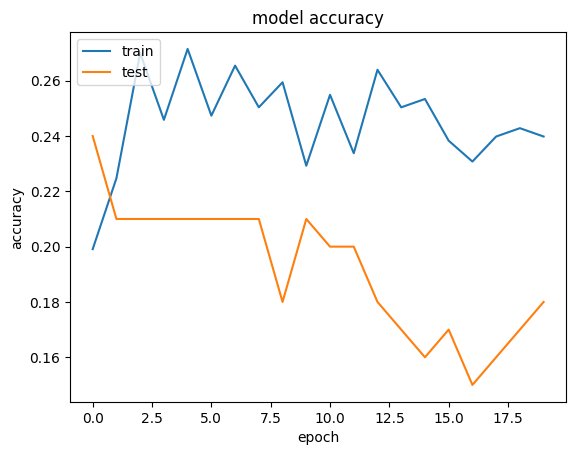

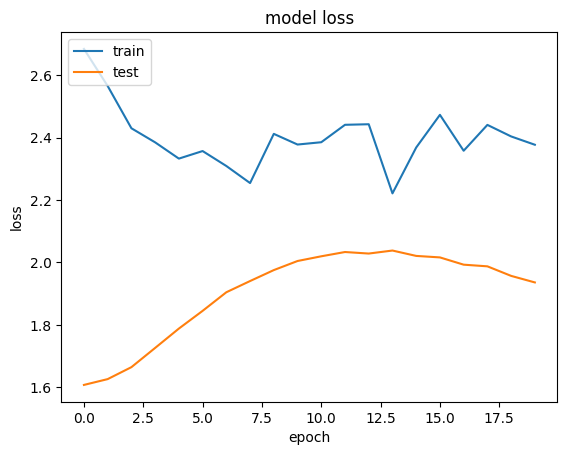

In [ ]:
plotting_history(history_con3d_2)

## Model 3 Conv3D

Key Changes
- 10 epochs and 39 batch size
- image size increased to 84X84
- took 13 image frames
- reduced cropping to 3 % from 10 %
- Reduced the learning rate to 0.0001


Update the generator function

In [11]:
# Modified generator function :

def generator_modified(source_path, folder_list, batch_size, x_dim, y_dim, img_idx):
    print( 'Source path = ', source_path, '; batch size =', batch_size)

    while True:
        t = np.random.permutation(folder_list)

# calculate the number of batches
        num_batches = int(len(t)/batch_size)

# we iterate over the number of batches
        for batch in range(num_batches):

# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,len(img_idx),x_dim,y_dim,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size
            for folder in range(batch_size):
# read all the images in the folder
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
#  Iterate over the frames/images of a folder to read them in
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)

#crop the images and resize them. Note that the images are of 2 different shape
#and the conv3D will throw error if the inputs in a batch have different shapes

# Cropping image by 3 % of original size Resizing the image 84,84
                    image = crop_and_resize_img(image, 0.03, (x_dim,y_dim))

#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do
            yield batch_data, batch_labels


# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,len(img_idx),x_dim,y_dim,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)

# Cropping image by 3 % of original size Resizing the image
                    image = crop_and_resize_img(image, 0.03, (x_dim,y_dim))

# Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [ ]:
num_epochs = 10
print ('# epochs =', num_epochs)

batch_size = 39
print ('# batch_size =', batch_size)

#list of image numbers you want to use for a particular video
img_indexs = [1,5,6,7,10,12,14,18,20,24,26,27,29]
print(len(img_indexs))

# epochs = 10
# batch_size = 39
13


In [ ]:
modelConv3D_3 = Sequential()

# First Conv3D Layer
modelConv3D_3.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(13, 84, 84, 3)))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2, 2, 2)))
modelConv3D_3.add(Dropout(0.3))  # Add dropout to prevent overfitting

# Second Conv3D Layer
modelConv3D_3.add(Conv3D(32, (3, 3, 3), padding='same'))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2, 2, 2)))
modelConv3D_3.add(Dropout(0.3))

# Third Conv3D Layer
modelConv3D_3.add(Conv3D(64, (3, 3, 3), padding='same'))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2, 2, 2)))
modelConv3D_3.add(Dropout(0.4))

# Fourth Conv3D Layer
modelConv3D_3.add(Conv3D(128, (3, 3, 3), padding='same'))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
modelConv3D_3.add(Dropout(0.4))

# Flatten and Fully Connected Layers
modelConv3D_3.add(Flatten())
modelConv3D_3.add(Dense(128, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.5))

modelConv3D_3.add(Dense(64, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.5))

# Output Layer
modelConv3D_3.add(Dense(5, activation='softmax'))

# Optimizer
optimiser_con3d_3 = optimizers.Adam(learning_rate=0.0001)  # Lower learning rate for better convergence

# Compile the model
modelConv3D_3.compile(optimizer=optimiser_con3d_3, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Print the model summary :
print (modelConv3D_3.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)                    │ (None, 13, 84, 84, 16)      │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 13, 84, 84, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 13, 84, 84, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 6, 42, 42, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 6, 42, 42, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 6, 42, 42, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 6, 42, 42, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 6, 42, 42, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 3, 21, 21, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 3, 21, 21, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_6 (Conv3D)                    │ (None, 3, 21, 21, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 3, 21, 21, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 3, 21, 21, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 1, 10, 10, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 10, 10, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_7 (Conv3D)                    │ (None, 1, 10, 10, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 1, 10, 10, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 1, 10, 10, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 1, 5, 5, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 711,877 (2.72 MB)

 Trainable params: 711,013 (2.71 MB)

 Non-trainable params: 864 (3.38 KB)

None


In [12]:
def call_generator_modified(batch_size,x_dim,y_dim,img_indexs):
  train_generator = generator_modified(train_path, train_doc, batch_size,x_dim,y_dim,img_indexs)
  val_generator = generator_modified(val_path, val_doc, batch_size,x_dim,y_dim,img_indexs)

  return train_generator, val_generator

In [ ]:
train_generator, val_generator = call_generator_modified(batch_size,84,84,img_indexs)
callbacks_list = set_model_dir_checkpoint()
steps_per_epoch, validation_steps = set_steps_per_epoch(batch_size)

In [ ]:
num_epochs

10

In [ ]:
history_con3d_3 = modelConv3D_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=None,
                    initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 39
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 45s/step - categorical_accuracy: 0.1929 - loss: 2.7123 Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 39

Epoch 1: saving model to model_init_2025-01-0409_13_26.676958/model-00001-2.73134-0.21116-1.61059-0.18000.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 860s 53s/step - categorical_accuracy: 0.1940 - loss: 2.7134 - val_categorical_accuracy: 0.1800 - val_loss: 1.6106 - learning_rate: 1.0000e-04
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - categorical_accuracy: 0.2350 - loss: 2.6201 
Epoch 2: saving model to model_init_2025-01-0409_13_26.676958/model-00002-2.54489-0.25490-1.61686-0.16000.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 262s 15s/step - categorical_accuracy: 0.2361 - loss: 2.6159 - val_categorical_accuracy: 0.1600 - val_loss: 1.6169 - learning_rate: 1.0000e-04
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - categorical_accuracy: 0.2493 - loss: 2.384

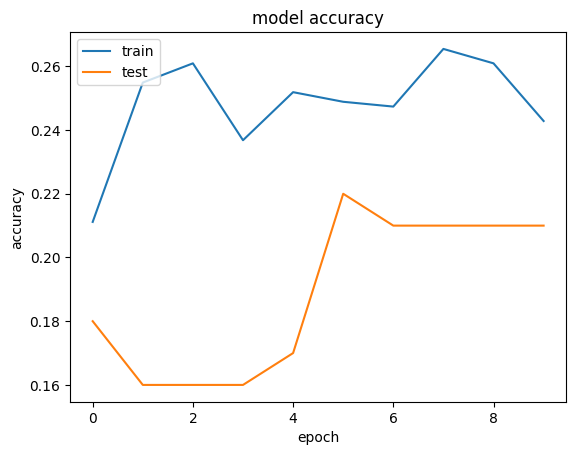

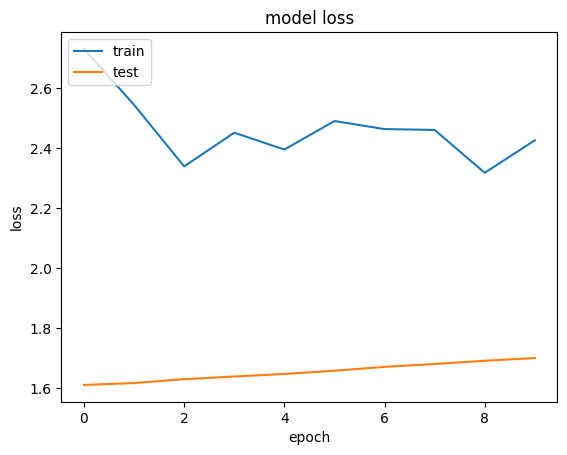

In [ ]:
plotting_history(history_con3d_3)

## Model 4 Conv3D



Key Changes
- 15 epochs and 50 batch size
- image size increased to 100X100
- Reduced the learning rate to 0.001
- reduce the params by reducing layers in model
- Global Average Pooling instead of Flatten
- check with early stop callback

In [ ]:
num_epochs = 15
print ('# epochs =', num_epochs)

batch_size = 50
print ('# batch_size =', batch_size)

#list of image numbers you want to use for a particular video
img_indexs = [0,3,6,9,11,13,15,17,20,23,25,27,29]
print(len(img_indexs))

# epochs = 15
# batch_size = 50
13


In [ ]:
modelConv3D_4 = Sequential()

# First Conv3D Layer
modelConv3D_4.add(Conv3D(8, (3, 3, 3), padding='same', input_shape=(13, 100, 100, 3)))
modelConv3D_4.add(Activation('relu'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
modelConv3D_4.add(Dropout(0.25))  # Slightly lower dropout

# Second Conv3D Layer
modelConv3D_4.add(Conv3D(16, (3, 3, 3), padding='same'))
modelConv3D_4.add(Activation('relu'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
modelConv3D_4.add(Dropout(0.25))

# Third Conv3D Layer
modelConv3D_4.add(Conv3D(32, (3, 3, 3), padding='same'))
modelConv3D_4.add(Activation('relu'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
modelConv3D_4.add(Dropout(0.3))

# Fourth Conv3D Layer
modelConv3D_4.add(Conv3D(64, (3, 3, 3), padding='same'))
modelConv3D_4.add(Activation('relu'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
modelConv3D_4.add(Dropout(0.3))

# Global Average Pooling instead of Flatten
modelConv3D_4.add(GlobalAveragePooling3D())

# Fully Connected Layers
modelConv3D_4.add(Dense(64, activation='relu'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Dropout(0.4))

# Output Layer
modelConv3D_4.add(Dense(5, activation='softmax'))

# Optimizer
optimiser_con3d_4 = optimizers.Adam(learning_rate=0.001)

# Compile the model
modelConv3D_4.compile(
    optimizer=optimiser_con3d_4,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)


In [ ]:
# Print the model summary :
print (modelConv3D_4.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_12 (Conv3D)                   │ (None, 13, 100, 100, 8)     │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 13, 100, 100, 8)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 13, 100, 100, 8)     │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_12 (MaxPooling3D)      │ (None, 6, 50, 50, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 6, 50, 50, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_13 (Conv3D)                   │ (None, 6, 50, 50, 16)       │           3,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 6, 50, 50, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 6, 50, 50, 16)       │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_13 (MaxPooling3D)      │ (None, 3, 25, 25, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 3, 25, 25, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_14 (Conv3D)                   │ (None, 3, 25, 25, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 3, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 3, 25, 25, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_14 (MaxPooling3D)      │ (None, 1, 12, 12, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1, 12, 12, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_15 (Conv3D)                   │ (None, 1, 12, 12, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 1, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 1, 12, 12, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_15 (MaxPooling3D)      │ (None, 1, 6, 6, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 78,565 (306.89 KB)

 Trainable params: 78,197 (305.46 KB)

 Non-trainable params: 368 (1.44 KB)

None


In [ ]:
train_generator, val_generator = call_generator_modified(batch_size,100,100,img_indexs)
callbacks_list = set_model_dir_checkpoint()
steps_per_epoch, validation_steps = set_steps_per_epoch(batch_size)

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
callbacks_list.append(early_stopping)

In [ ]:
num_epochs

15

In [ ]:
callbacks_list

In [ ]:
history_con3d_4 = modelConv3D_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=None,
                    initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 50
Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 77s/step - categorical_accuracy: 0.2482 - loss: 2.2252  Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 50

Epoch 1: saving model to model_init_2025-01-0409_13_26.676958/model-00001-2.09750-0.24887-1.62166-0.22000.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1219s 92s/step - categorical_accuracy: 0.2482 - loss: 2.2167 - val_categorical_accuracy: 0.2200 - val_loss: 1.6217 - learning_rate: 0.0010
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - categorical_accuracy: 0.2509 - loss: 1.9730 
Epoch 2: saving model to model_init_2025-01-0409_13_26.676958/model-00002-1.91008-0.26998-1.64697-0.22000.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 250s 18s/step - categorical_accuracy: 0.2522 - loss: 1.9688 - val_categorical_accuracy: 0.2200 - val_loss: 1.6470 - learning_rate: 0.0010
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - categorical_accuracy: 0.2989 - loss: 1.8939 
Epo

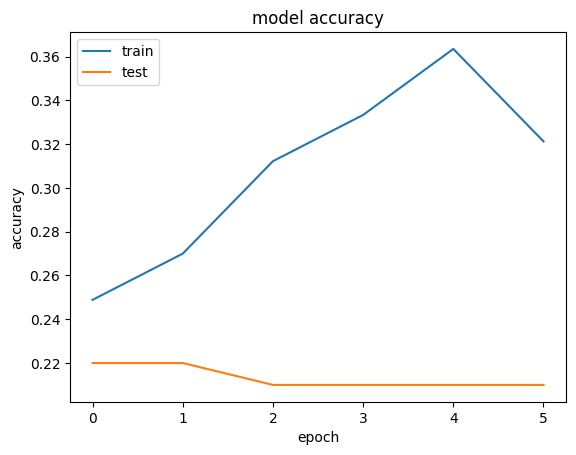

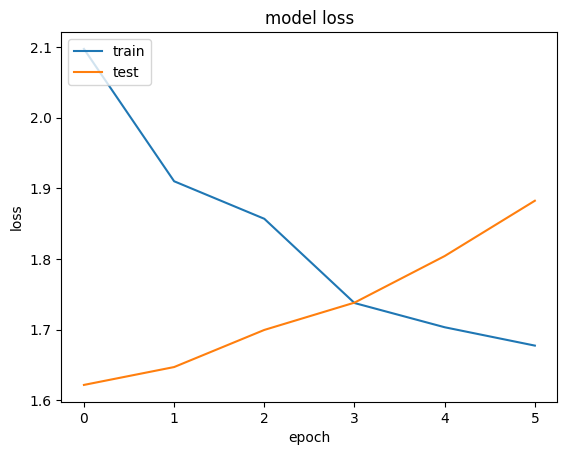

In [ ]:
plotting_history(history_con3d_4)

## Model 5 Conv3D



batch size 30, increased image inputs to 30 , image size recuced to 84 epochs 30

In [ ]:
num_epochs = 20
print ('# epochs =', num_epochs)

batch_size = 30
print ('# batch_size =', batch_size)

#list of image numbers you want to use for a particular video
img_indexs = [x for x in range(0, 30)]
print(len(img_indexs))

# epochs = 30
# batch_size = 30
30


In [ ]:
modelConv3D_5 = Sequential()

modelConv3D_5.add(Conv3D(8, (3,3,3), padding='same', input_shape=(30,84,84,3)))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Flatten())
modelConv3D_5.add(Dense(64, activation='relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Dense(64, activation='relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Dense(5, activation='softmax'))

#write your optimizer
optimiser_con3d_5 = optimizers.Adam(learning_rate=0.0002)

# compile model :
modelConv3D_5.compile(optimizer=optimiser_con3d_5, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelConv3D_5.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_24 (Conv3D)                   │ (None, 30, 84, 84, 8)       │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 30, 84, 84, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 30, 84, 84, 8)       │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_24 (MaxPooling3D)      │ (None, 15, 42, 42, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_25 (Conv3D)                   │ (None, 15, 42, 42, 16)      │           3,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_25 (Activation)           │ (None, 15, 42, 42, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 15, 42, 42, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_25 (MaxPooling3D)      │ (None, 7, 21, 21, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_26 (Conv3D)                   │ (None, 7, 21, 21, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 7, 21, 21, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_26 (Activation)           │ (None, 7, 21, 21, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_26 (MaxPooling3D)      │ (None, 3, 10, 10, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_27 (Conv3D)                   │ (None, 3, 10, 10, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_27 (Activation)           │ (None, 3, 10, 10, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 3, 10, 10, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_27 (MaxPooling3D)      │ (None, 1, 5, 5, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 181,285 (708.14 KB)

 Trainable params: 180,789 (706.21 KB)

 Non-trainable params: 496 (1.94 KB)

None


In [ ]:
train_generator, val_generator = call_generator_modified(batch_size,84,84,img_indexs)
callbacks_list = set_model_dir_checkpoint()
steps_per_epoch, validation_steps = set_steps_per_epoch(batch_size)

In [ ]:
num_epochs

30

In [ ]:
history_con3d_4 = modelConv3D_5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=None,
                    initial_epoch=0)

NameError: name 'modelConv3D_5' is not defined

##Model 6 : CNN - LSTM Model 1

In [ ]:
num_epochs = 8
print ('# epochs =', num_epochs)

batch_size = 8
print ('# batch_size =', batch_size)

#list of image numbers you want to use for a particular video
img_indexs = [3,6,9,12,15,18,21,27]
print(len(img_indexs))

# epochs = 8
# batch_size = 8
8


In [ ]:
# Optimized Input Shape
input_shape = (8, 64, 64, 3)  # Reduced spatial dimensions to 64 to reduce computation.

cnn_lstm_1 = Sequential()

# First TimeDistributed Conv2D Layer
cnn_lstm_1.add(TimeDistributed(Conv2D(8, (3, 3), padding='same', activation='relu'),
                                       input_shape=input_shape))  # Reduced filters
cnn_lstm_1.add(TimeDistributed(BatchNormalization()))
cnn_lstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))  # Pooling reduces computation

# Second TimeDistributed Conv2D Layer
cnn_lstm_1.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu')))  # Reduced filters
cnn_lstm_1.add(TimeDistributed(BatchNormalization()))
cnn_lstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

# # Third TimeDistributed Conv2D Layer
# cnn_lstm_1.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))  # Reduced filters
# cnn_lstm_1.add(TimeDistributed(BatchNormalization()))
# cnn_lstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flatten Layer
cnn_lstm_1.add(TimeDistributed(Flatten()))

# LSTM Layer
cnn_lstm_1.add(LSTM(64, return_sequences=False))  # Reduced LSTM units
cnn_lstm_1.add(Dropout(0.25))

# Fully Connected Layers
cnn_lstm_1.add(Dense(64, activation='relu'))  # Reduced dense units
cnn_lstm_1.add(Dropout(0.25))

# Output Layer
cnn_lstm_1.add(Dense(5, activation='softmax'))

# Optimizer
optimiser_optimized = optimizers.Adam(learning_rate=0.0005)  # Higher learning rate to converge faster

# Compile Model
cnn_lstm_1.compile(optimizer=optimiser_optimized, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print(cnn_lstm_1.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 8, 64, 64, 8)        │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 8, 64, 64, 8)        │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 8, 32, 32, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 8, 32, 32, 16)       │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 8, 32, 32, 16)       │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 8, 16, 16, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 8, 4096)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │       1,065,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,071,189 (4.09 MB)

 Trainable params: 1,071,141 (4.09 MB)

 Non-trainable params: 48 (192.00 B)

None


In [ ]:
train_generator, val_generator = call_generator_modified(batch_size,64,64,img_indexs)
callbacks_list = set_model_dir_checkpoint()
steps_per_epoch, validation_steps = set_steps_per_epoch(batch_size)

In [ ]:
num_epochs

8

In [ ]:
history_lstm_1 = cnn_lstm_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=None,
                    initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 8
Epoch 1/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - categorical_accuracy: 0.2207 - loss: 1.6583 Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 8

Epoch 1: saving model to model_init_2025-01-0607_14_11.156559/model-00001-1.63764-0.24133-1.59815-0.28000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 2122s 26s/step - categorical_accuracy: 0.2210 - loss: 1.6581 - val_categorical_accuracy: 0.2800 - val_loss: 1.5982 - learning_rate: 5.0000e-04
Epoch 2/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - categorical_accuracy: 0.2811 - loss: 1.5962
Epoch 2: saving model to model_init_2025-01-0607_14_11.156559/model-00002-1.59094-0.28205-1.57915-0.22000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 525ms/step - categorical_accuracy: 0.2811 - loss: 1.5962 - val_categorical_accuracy: 0.2200 - val_loss: 1.5792 - learning_rate: 5.0000e-04
Epoch 3/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - categorical_accuracy: 0.3332 - loss: 1.540

##Model 7 CNN- LSTM model 2

In [13]:
num_epochs = 10
print ('# epochs =', num_epochs)

batch_size = 16
print ('# batch_size =', batch_size)

#list of image numbers you want to use for a particular video
img_indexs = [3,6,9,12,15,18,21,27]
print(len(img_indexs))

# epochs = 10
# batch_size = 16
8


In [14]:
# Optimized Input Shape
input_shape = (8, 64, 64, 3)  # Reduced spatial dimensions to 64 to reduce computation.

cnn_lstm_1 = Sequential()

# First TimeDistributed Conv2D Layer
cnn_lstm_1.add(TimeDistributed(Conv2D(8, (3, 3), padding='same', activation='relu'),
                                       input_shape=input_shape))  # Reduced filters
cnn_lstm_1.add(TimeDistributed(BatchNormalization()))
cnn_lstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))  # Pooling reduces computation

# Second TimeDistributed Conv2D Layer
cnn_lstm_1.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu')))  # Reduced filters
cnn_lstm_1.add(TimeDistributed(BatchNormalization()))
cnn_lstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

# Third TimeDistributed Conv2D Layer
cnn_lstm_1.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))  # Reduced filters
cnn_lstm_1.add(TimeDistributed(BatchNormalization()))
cnn_lstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flatten Layer
cnn_lstm_1.add(TimeDistributed(Flatten()))

# LSTM Layer
cnn_lstm_1.add(LSTM(64, return_sequences=False))  # Reduced LSTM units
cnn_lstm_1.add(Dropout(0.25))

# Fully Connected Layers
cnn_lstm_1.add(Dense(64, activation='relu'))  # Reduced dense units
cnn_lstm_1.add(Dropout(0.25))

# Output Layer
cnn_lstm_1.add(Dense(5, activation='softmax'))

# Optimizer
optimiser_optimized = optimizers.Adam(learning_rate=0.0005)  # Higher learning rate to converge faster

# Compile Model
cnn_lstm_1.compile(optimizer=optimiser_optimized, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print(cnn_lstm_1.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 8, 64, 64, 8)        │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 8, 64, 64, 8)        │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 8, 32, 32, 8)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 8, 32, 32, 16)       │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 8, 32, 32, 16)       │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 8, 16, 16, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 8, 16, 16, 32)       │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 8, 16, 16, 32)       │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 8, 8, 8, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 8, 2048)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │         540,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 551,669 (2.10 MB)

 Trainable params: 551,557 (2.10 MB)

 Non-trainable params: 112 (448.00 B)

None


In [17]:
train_generator, val_generator = call_generator_modified(batch_size,64,64,img_indexs)
callbacks_list = set_model_dir_checkpoint()
steps_per_epoch, validation_steps = set_steps_per_epoch(batch_size)

In [18]:
history_lstm_2 = cnn_lstm_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=None,
                    initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 16
Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 61s/step - categorical_accuracy: 0.2640 - loss: 1.6194  Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 16

Epoch 1: saving model to model_init_2025-01-0711_55_54.355570/model-00001-1.60509-0.28959-1.56490-0.29000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 2967s 72s/step - categorical_accuracy: 0.2646 - loss: 1.6191 - val_categorical_accuracy: 0.2900 - val_loss: 1.5649 - learning_rate: 5.0000e-04
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - categorical_accuracy: 0.3725 - loss: 1.5370
Epoch 2: saving model to model_init_2025-01-0711_55_54.355570/model-00002-1.56846-0.31976-1.53706-0.31000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - categorical_accuracy: 0.3713 - loss: 1.5377 - val_categorical_accuracy: 0.3100 - val_loss: 1.5371 - learning_rate: 5.0000e-04
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - categorical_accuracy: 0.3333 - loss: 1.

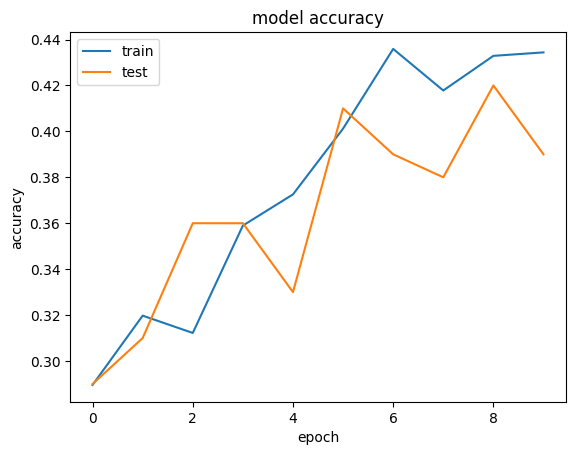

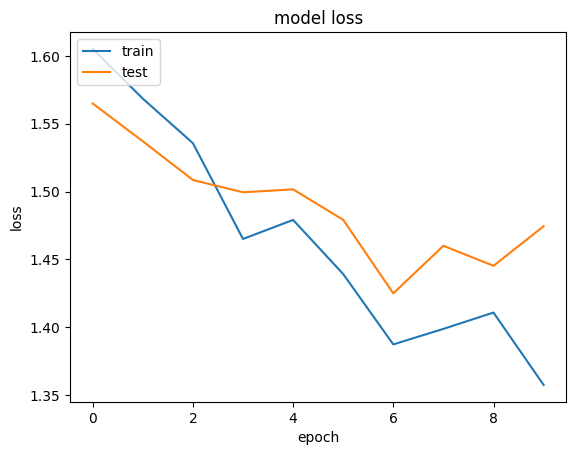

In [19]:
plotting_history(history_lstm_2)

In [ ]:
import psutil
ram = psutil.virtual_memory()
print(f"Total RAM: {ram.total / 1e9:.2f} GB")
print(f"Used RAM: {ram.used / 1e9:.2f} GB")
print(f"Free RAM: {ram.available / 1e9:.2f} GB")


Total RAM: 13.61 GB
Used RAM: 1.43 GB
Free RAM: 11.85 GB


In [ ]:
import torch
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Total GPU Memory:", torch.cuda.get_device_properties(0).total_memory / 1e9, "GB")


GPU Available: True
GPU Name: Tesla T4
Total GPU Memory: 15.835660288 GB


Model LSTM trial

In [13]:
num_epochs = 10
print ('# epochs =', num_epochs)

batch_size = 16
print ('# batch_size =', batch_size)

#list of image numbers you want to use for a particular video
img_indexs = [3,6,9,12,15,18,21,27]
print(len(img_indexs))

# epochs = 10
# batch_size = 16
8


In [14]:
# Optimized Input Shape
input_shape = (8, 64, 64, 3)

cnn_lstm_optimized = Sequential()

# First TimeDistributed Conv2D Layer
cnn_lstm_optimized.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                                       input_shape=input_shape))  # Increased filters
cnn_lstm_optimized.add(TimeDistributed(BatchNormalization()))
cnn_lstm_optimized.add(TimeDistributed(MaxPooling2D((2, 2))))

# Second TimeDistributed Conv2D Layer
cnn_lstm_optimized.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))  # Increased filters
cnn_lstm_optimized.add(TimeDistributed(BatchNormalization()))
cnn_lstm_optimized.add(TimeDistributed(MaxPooling2D((2, 2))))

# Third TimeDistributed Conv2D Layer
cnn_lstm_optimized.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))  # Increased filters
cnn_lstm_optimized.add(TimeDistributed(BatchNormalization()))
cnn_lstm_optimized.add(TimeDistributed(MaxPooling2D((2, 2))))

# Fourth TimeDistributed Conv2D Layer (New)
cnn_lstm_optimized.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))  # New Conv2D layer
cnn_lstm_optimized.add(TimeDistributed(BatchNormalization()))
cnn_lstm_optimized.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flatten Layer
cnn_lstm_optimized.add(TimeDistributed(Flatten()))

# LSTM Layer
cnn_lstm_optimized.add(LSTM(128, return_sequences=False))  # Increased LSTM units for better feature learning
cnn_lstm_optimized.add(Dropout(0.4))  # Slightly increased dropout for regularization

# Fully Connected Layers
cnn_lstm_optimized.add(Dense(128, activation='relu'))  # Increased dense units
cnn_lstm_optimized.add(BatchNormalization())  # Added BatchNormalization to dense layers
cnn_lstm_optimized.add(Dropout(0.4))

# Output Layer
cnn_lstm_optimized.add(Dense(5, activation='softmax'))

# Optimizer
optimiser_optimized = optimizers.Adam(learning_rate=0.0001)  # Slightly reduced learning rate for stable training

# Compile Model
cnn_lstm_optimized.compile(optimizer=optimiser_optimized, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print(cnn_lstm_optimized.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 8, 64, 64, 16)       │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 8, 64, 64, 16)       │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 8, 32, 32, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 8, 32, 32, 32)       │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 8, 32, 32, 32)       │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 8, 16, 16, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 8, 16, 16, 64)       │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 8, 16, 16, 64)       │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 8, 8, 8, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 8, 8, 8, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 8, 8, 8, 128)        │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 8, 4, 4, 128)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 8, 2048)             │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │       1,114,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,230,693 (4.69 MB)

 Trainable params: 1,229,957 (4.69 MB)

 Non-trainable params: 736 (2.88 KB)

None


In [18]:
train_generator, val_generator = call_generator_modified(batch_size,64,64,img_indexs)
callbacks_list = set_model_dir_checkpoint()
steps_per_epoch, validation_steps = set_steps_per_epoch(batch_size)

In [ ]:
history_lstm_3 = cnn_lstm_optimized.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=None,
                    initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 16
Epoch 1/10
 4/42 ━━━━━━━━━━━━━━━━━━━━ 21:31 34s/step - categorical_accuracy: 0.2279 - loss: 2.4955

## Model 8 Pre-trained model for Transfer learning

Why it's a good fit:
Optimized for spatiotemporal data.
Memory-efficient with manageable parameters.
Pretrained On: Kinetics-400 dataset.
Frameworks: PyTorch.

In [ ]:
num_epochs = 5
print ('# epochs =', num_epochs)

batch_size = 4
print ('# batch_size =', batch_size)

#list of image numbers you want to use for a particular video
img_indexs = [3,6,9,12,15,18,21,27]
print(len(img_indexs))

# epochs = 5
# batch_size = 4
8


In [ ]:
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling3D, LSTM
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

def build_3d_resnet(input_shape, num_classes):
    # Load pre-trained 2D ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(input_shape[1], input_shape[2], input_shape[3]))

    # Freeze some layers of ResNet to leverage transfer learning
    for layer in base_model.layers[:-10]:  # Fine-tuning last 10 layers
        layer.trainable = False

    # Build model using TimeDistributed wrapper
    model = Sequential()
    model.add(TimeDistributed(base_model, input_shape=input_shape))  # Apply ResNet50 to each frame
    model.add(TimeDistributed(GlobalAveragePooling2D()))  # Pooling after applying ResNet50 to each frame
    model.add(LSTM(128))  # LSTM layer to process temporal information
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation='softmax'))  # Final classification layer

    return model

# Define model parameters
input_shape = (8, 64, 64, 3)  # 13 frames, 64x64 images, 3 channels (RGB)
num_classes = 5  # Number of gesture categories

# Build and compile the model
model_resnet = build_3d_resnet(input_shape, num_classes)
optimiser_resnet = optimizers.Adam(learning_rate=0.0001)
model_resnet.compile(optimizer=optimiser_resnet, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Display model summary
print(model_resnet.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_8 (TimeDistributed) │ (None, 8, 2, 2, 2048)       │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 8, 2048)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 128)                 │       1,114,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,719,493 (94.30 MB)

 Trainable params: 5,597,445 (21.35 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

None


In [ ]:
train_generator, val_generator = call_generator_modified(batch_size,64,64,img_indexs)
callbacks_list = set_model_dir_checkpoint()
steps_per_epoch, validation_steps = set_steps_per_epoch(batch_size)

In [ ]:
history_resnet= model_resnet.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=num_epochs,
    callbacks=callbacks_list,
    verbose=1
)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 4
Epoch 1/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - categorical_accuracy: 0.2324 - loss: 1.6568Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 4

Epoch 1: saving model to model_init_2025-01-0510_42_33.411284/model-00001-1.64975-0.22624-1.61150-0.19000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 130s 434ms/step - categorical_accuracy: 0.2323 - loss: 1.6568 - val_categorical_accuracy: 0.1900 - val_loss: 1.6115 - learning_rate: 1.0000e-04
Epoch 2/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - categorical_accuracy: 0.1884 - loss: 1.6256
Epoch 2: saving model to model_init_2025-01-0510_42_33.411284/model-00002-1.61955-0.21569-1.59207-0.17000.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 55s 334ms/step - categorical_accuracy: 0.1885 - loss: 1.6256 - val_categorical_accuracy: 0.1700 - val_loss: 1.5921 - learning_rate: 1.0000e-04
Epoch 3/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - categorical_accuracy: 0.2762 -

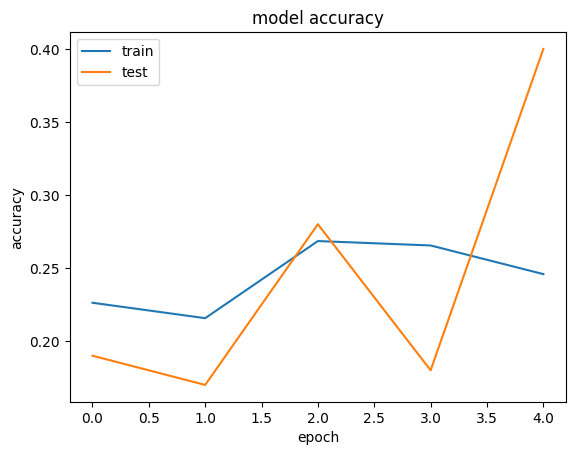

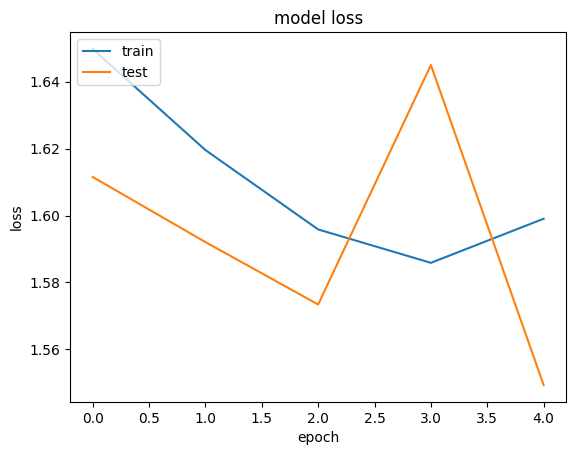

In [ ]:
plotting_history(history_resnet)

## Model 9 Pre-trained model for Transfer learning updated batch size and epochs

In [ ]:
num_epochs = 8
print ('# epochs =', num_epochs)

batch_size = 8
print ('# batch_size =', batch_size)

#list of image numbers you want to use for a particular video
img_indexs = [3,6,9,12,15,18,21,27]
print(len(img_indexs))

# epochs = 8
# batch_size = 8
8


No change in model so refrencing same model 8

In [ ]:
train_generator, val_generator = call_generator_modified(batch_size,64,64,img_indexs)
callbacks_list = set_model_dir_checkpoint()
steps_per_epoch, validation_steps = set_steps_per_epoch(batch_size)

In [ ]:
history_resnet_updated= model_resnet.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=num_epochs,
    callbacks=callbacks_list,
    verbose=1
)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 8
Epoch 1/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - categorical_accuracy: 0.2299 - loss: 1.6278Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 8

Epoch 1: saving model to model_init_2025-01-0510_42_33.411284/model-00001-1.61633-0.26244-1.57956-0.23000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 119s 788ms/step - categorical_accuracy: 0.2303 - loss: 1.6277 - val_categorical_accuracy: 0.2300 - val_loss: 1.5796 - learning_rate: 1.0000e-04
Epoch 2/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - categorical_accuracy: 0.2547 - loss: 1.5830
Epoch 2: saving model to model_init_2025-01-0510_42_33.411284/model-00002-1.57782-0.27903-1.52668-0.33000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 51s 616ms/step - categorical_accuracy: 0.2550 - loss: 1.5829 - val_categorical_accuracy: 0.3300 - val_loss: 1.5267 - learning_rate: 1.0000e-04
Epoch 3/8
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - categorical_accuracy: 0.2799 - loss: 1.5